## Library Imports

In [923]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm
import pandas as pd
import matplotlib as mpl
from itertools import count

%matplotlib inline

## Raw Data Imports

In [924]:
EPO_IPC = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_IPC.txt',sep='|')
EPO_Patents = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_EPO_Inventor_reg.txt',sep='|')
EPO_Citations = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Citation data/202001_EPO_CITATIONS.txt',sep='|')
EPO_Citations['Cited_Appln_id'] = EPO_Citations['Cited_Appln_id'].fillna(0).astype(int)

In [925]:
EPO_Patents_PURE = EPO_Patents.loc[EPO_Patents['reg_share'] == 1] # Regional share is 1
EPO_Patents_PURE_GB = EPO_Patents_PURE.loc[EPO_Patents_PURE['ctry_code'] == 'GB'] # Region is also GB
EPO_Patents_CLEAN = EPO_Patents_PURE_GB[['appln_id','reg_code']].drop_duplicates()
IPC_Patent_MERGE = EPO_Patents_CLEAN.merge(EPO_IPC, left_on='appln_id', right_on='appln_id')
Patent_IDS = IPC_Patent_MERGE['appln_id'].unique() # All patent IDS with known information
Citations_CHECK = EPO_Citations[EPO_Citations['Citing_appln_id'].isin(Patent_IDS)]
Citations_READY = Citations_CHECK[Citations_CHECK['Cited_Appln_id'].isin(Patent_IDS)] 
edge_list = np.array(Citations_READY[['Cited_Appln_id','Citing_appln_id']]) # Edge list where only with known patents

In [926]:
Patent_IPCS_FF = IPC_Patent_MERGE[IPC_Patent_MERGE['appln_id'].isin(list(graph.nodes()))]
Patent_IPCS_FF['IPC'] = Patent_IPCS_FF['IPC'].astype(str).str[:1] # Reduce IPC to 1 level
Patent_IPCS_FFD = Patent_IPCS_FF.drop(columns='reg_code').drop_duplicates() # FROM HERE NO LONGER CONSIDERING LOCATION
Patent_IPCS_FFD_red = Patent_IPCS_FFD[['appln_id','IPC']]

/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_74818/1203989907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Patent_IPCS_FF['IPC'] = Patent_IPCS_FF['IPC'].astype(str).str[:1] # Reduce IPC to 1 level


In [927]:
edge_list_cut = edge_list[:]
graph = nx.DiGraph()
graph.add_edges_from(edge_list_cut)
len(edge_list_cut)

23190

In [928]:
ID_TABLE = list(Patent_IPCS_FFD['appln_id'])
IPC_TABLE = []
for i in tqdm(range(len(Patent_IPCS_FFD))):
    current_IPCs = list(Patent_IPCS_FFD.loc[Patent_IPCS_FFD['appln_id'] == list(Patent_IPCS_FFD['appln_id'])[i]]['IPC'])
    IPC_TABLE.append(list(set(current_IPCs)))

IPC_TABLE = [''.join(sublist) for sublist in list(IPC_TABLE)] # Flatten

100%|████████████████████████████████████| 36273/36273 [02:28<00:00, 244.42it/s]


In [929]:
Attributes_IPC = dict(zip(ID_TABLE, IPC_TABLE))
nx.set_node_attributes(graph, 'N', name="IPC")
nx.set_node_attributes(graph, Attributes_IPC, name="IPC")

In [930]:
# Not required to refresh
Attributes = IPC_Patent_MERGE[['appln_id','prio_year']].astype(int).drop_duplicates().set_index('appln_id').T.to_dict('list')
Attributes = {key: value[0] for key, value in Attributes.items()}

In [931]:
nx.set_node_attributes(graph, Attributes, name="date")

In [932]:
pos_spring = nx.spring_layout(graph)
pos = {list(graph.nodes())[i]: (list(dict(pos_spring).values())[i][0], list(nx.get_node_attributes(graph, 'date').values())[i], list(dict(pos_spring).values())[i][1]) for i in range(len(graph.nodes))}
nx.set_node_attributes(graph, pos, name="pos")

KeyboardInterrupt: 

In [ ]:
graph.nodes(data=True)

## 3D Plotting

In [ ]:
def network_plot_3D(G, angle, save, IPC_FILTER_SELECTION):

    # extracting info
    pos = nx.get_node_attributes(G, 'pos')
    n = G.number_of_nodes()
    dates = list(nx.get_node_attributes(G, 'date').values())
    IPCs = list(nx.get_node_attributes(G, 'IPC').values())

    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(12,12))
        ax = fig.gca(projection='3d')
        
        jcounter = 0
        for key, value in pos.items(): # nodes
            xi = value[0]
            yi = value[1]
            zi = value[2]
            relative_output = (10+10*G.out_degree(key)) # Highlight only those with known IPC
            #relative_output = (10+100*G.out_degree(key))/(1+10*abs(max(dates)-value[1])) 
            if IPC_FILTER_SELECTION in IPCs[jcounter]:
                ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = 'coolwarm', s=relative_output, edgecolors='k', alpha=0.9) # Out degree since those CITE the most
            else:
                ax.scatter(xi, yi, zi, c=value[1], norm=mpl.colors.Normalize(vmin=min(dates),vmax=max(dates)), cmap = 'coolwarm', s=relative_output, edgecolors='k', alpha=0.1)
                
            #ax.text(xi, yi, zi+0.1, s=IPCs[jcounter], c='b', fontsize=7)
            
            jcounter += 1
            
        c_selection = mpl.cm.coolwarm(np.linspace(0,1,int(abs(max(dates)-min(dates)))+1)) # Edge Colors
        
        for i,j in enumerate(G.edges()): # edges
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            ax.plot(x, y, z, c=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.5, linewidth=0.5)
            #ax.quiver(x[1], y[1], z[1], x[0]-x[1], y[0]-y[1], z[0]-z[1], color=c_selection[int(abs(pos[j[1]][1]-min(dates)))], alpha=0.5, linewidth=0.5)
            
    # viewpoint
    ax.set_box_aspect([1,2,1])
    ax.view_init(30, angle)
            
    if save is not False:
        file_dir = "/Users/joebacchus/Desktop/3D_plots/"+str(angle)+".png"
        plt.savefig(file_dir, dpi=300)
        plt.close("all")
        print('Done.')
        
    plt.show()
    
    return

In [ ]:
network_plot_3D(graph, 155, False, '')

In [ ]:
for k in tqdm(range(0,20,1)):

   angle = k*5+150
    
   network_plot_3D(graph, angle, True, '')

In [787]:
graph_attributes = pd.DataFrame(list(np.array(graph.nodes(data=True)).T[1]))
graph_attributes['out_deg'] = np.array(graph.out_degree()).T[1]
graph_attributes

,IPC,date,pos,out_deg
0,AC,1977,"(0.07177647203207016, 1977, 0.49677515029907227)",5
1,AC,1978,"(-0.9184932112693787, 1978, 0.3886132836341858)",0
2,AC,1977,"(0.8802996277809143, 1977, -0.1639411598443985)",3
3,AC,1978,"(0.9638834595680237, 1978, 0.16361649334430695)",0
4,AC,1978,"(0.7511773705482483, 1978, 0.0923292338848114)",2
...,...,...,...,...
3640,N,1985,"(0.6088626384735107, 1985, -0.7900161147117615)",0
3641,N,1983,"(-0.7877508997917175, 1983, -0.27917155623435974)",1
3642,N,1985,"(-0.8239771127700806, 1985, -0.29056641459465027)",0
3643,N,1985,"(0.7051346898078918, 1985, -0.6444802284240723)",0


In [830]:
graph_dates = sorted(list(set(nx.get_node_attributes(graph, 'date').values())))
deg_stored = []
for i in range(len(graph_dates)):
    deg_stored.append(dict(graph_attributes.loc[graph_attributes['date'] == graph_dates[i]]['out_deg'].value_counts()))

deg_stored

[{1: 49, 2: 18, 3: 12, 5: 3, 6: 2, 0: 2, 8: 1, 4: 1},
 {1: 158, 2: 42, 0: 19, 3: 16, 4: 12, 5: 3, 8: 2, 7: 1, 9: 1, 20: 1, 6: 1},
 {1: 200, 0: 64, 2: 36, 3: 21, 4: 11, 5: 6, 6: 2, 10: 2, 7: 2, 14: 1, 8: 1},
 {1: 227, 0: 125, 2: 57, 3: 23, 4: 15, 6: 5, 5: 3, 12: 1, 13: 1, 8: 1, 7: 1},
 {1: 237,
  0: 199,
  2: 55,
  3: 19,
  6: 8,
  4: 8,
  5: 3,
  9: 2,
  10: 2,
  12: 1,
  7: 1,
  13: 1},
 {0: 302, 1: 234, 2: 58, 3: 13, 5: 6, 4: 6, 6: 3},
 {0: 425, 1: 164, 2: 31, 3: 9},
 {0: 455, 1: 65, 3: 4, 2: 3},
 {0: 172, 1: 10}]

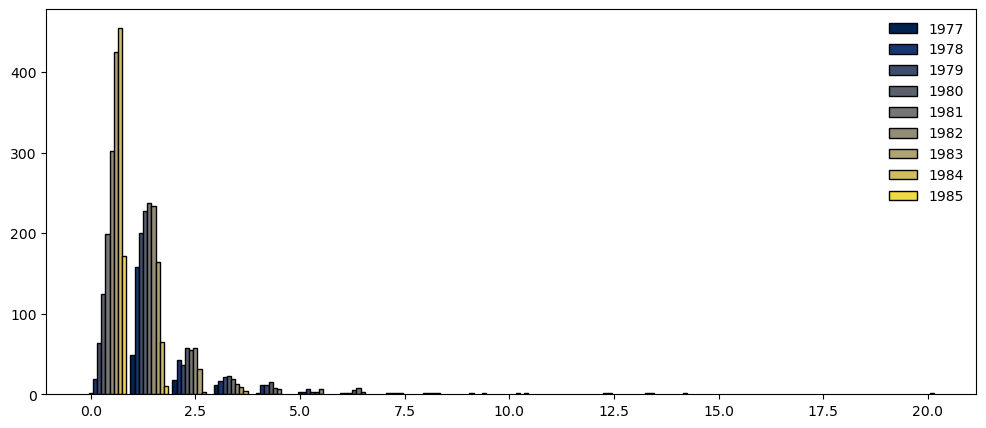

In [889]:
plt.figure(figsize = (12,5))
col_hist = mpl.cm.cividis(np.arange(0,len(deg_stored),1)*30)

for i in range(len(deg_stored)): 
    plt.bar(np.array(list(deg_stored[i].keys()))+i/10, deg_stored[i].values(), 0.1, color=col_hist[i],alpha=1,labjupyter notebook listel=graph_dates[i],edgecolor='black')
    
plt.xticks(fontsize=10)
plt.legend(frameon=False)
plt.show()

SyntaxError: invalid syntax (1373106854.py, line 1)

In [910]:
IPC = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_all_IPC_2.csv')

,Citing_appln_id,ipc_class_symbol
0,64,D21F 1/32
1,64,D21G 9/00
2,64,G01N 15/08
3,76,A47C 7/46
4,76,B60N 2/66
...,...,...
300842,509041326,G01J 1/16
300843,509041326,G01N 21/31
300844,509041326,G01N 21/3504
300845,509351327,E04B 1/41


In [911]:
cit = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_patent_citations.csv')

,source,target,time
0,EP19800103907,EP19790300134,1978
1,EP19800201077,EP19790300134,1978
2,EP19800201077,EP19790300251,1978
3,EP19790301557,EP19780300473,1979
4,EP19790300251,EP19780300203,1979
...,...,...,...
19762,EP20170794629,EP20090784654,2017
19763,EP20180752650,EP20090756784,2018
19764,EP20180746115,EP20080839560,2018
19765,EP20180752650,EP20130780381,2018


In [912]:
pat = pd.read_csv('/Users/joebacchus/Desktop/Bartlett CASA/Data Updated/Patents/UK_Patents_cited_wIPC.csv')


,app_nbr,appln_id,pub_nbr,person_id,inv_name,address,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC
0,EP20020258685,1303,1324097,2975,"Maddison, John R.","10 Lonsdale Gardens,Tunbridge Wells, Kent TN1 1NU",UKJ42,GB,1.0,0.5,2001,2002,G02B021/00
1,EP20020258685,1303,1324097,2976,"Clinch, Noah F.","10 Lonsdale Gardens,Tunbridge Wells, Kent TN1 1NU",UKJ42,GB,1.0,0.5,2001,2002,G02B021/00
2,EP20060250283,1972,1691541,49614001,"Gouch, Martin Philip","16 Edenhall Close,Hemel Hempstead,Hertfordshir...",UKH23,GB,1.0,1.0,2005,2006,G02B007/38
3,EP20060251704,1977,1717134,5487,"Hayes, Anthony","68 Cheltenham Crescent Runcorn,Cheshire WA7 4YT",UKD71,GB,1.0,1.0,2005,2006,B62D053/08
4,EP20060794909,2112,1952644,5984,"JAMES, Jason, Lee","6 Cauldecott Close,Northampton NN4 9QN",UKF24,GB,1.0,1.0,2005,2006,H04Q001/14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76162,EP20180191464,498998508,3460790,54515660,"HOGGARTH, Marcus","33 Lancaster Road,St. Albans, Hertfordshire AL...",UKH23,GB,1.0,0.2,2017,2018,G10K011/178
76163,EP20180191464,498998508,3460790,69754509,"BERNUCHON, Pierre","c/o Native,5 Garden Walk,London, EC2A 3EQ",UKI12,GB,1.0,0.2,2017,2018,G10K011/178
76164,EP20180191464,498998508,3460790,69856025,"MINGAY, David","c/o Native,5 Garden Walk,London, EC2A 3EQ",UKI12,GB,1.0,0.2,2017,2018,G10K011/178
76165,EP20180191464,498998508,3460790,69888468,"DODDS, Harriet","c/o Native,5 Garden Walk,London, EC2A 3EQ",UKI12,GB,1.0,0.2,2017,2018,G10K011/178
